# Pipeline (на тренировочном датасете): Abalone — прогноз `Rings`

**Цель:** построить полный ML-пайплайн (EDA → подготовка данных → обучение → оценка → важность признаков) на датасете `abalone.csv`.

**Важно по заданию:**
1. В каждом ключевом шаге добавлены короткие пояснения *почему выбран именно такой подход* (особенно — перевод категориальных данных в числовые).
2. Используются текстовые/Markdown-блоки, чтобы ноутбук читался как отчёт.
3. Для сравнения берём **ровно 2 модели** (разных типов):  
   - `Ridge` — регуляризованная линейная регрессия (хороший «прозрачный» базовый ориентир)  
   - `RandomForestRegressor` — нелинейная модель на деревьях (умеет ловить сложные зависимости)


## Содержание

1. Импорт библиотек и загрузка данных  
2. Описание данных  
3. EDA: типы, пропуски, базовая статистика, распределения, выбросы  
4. Преобразование категориальных признаков в числовые (пример OHE для `Sex`)  
5. Взаимосвязи признаков и таргета (**Pearson + Spearman**, графики)  
6. Постановка задачи  
7. Препроцессинг (Pipeline/ColumnTransformer)  
8. Сравнение **2 моделей** по кросс-валидации  
9. Обучение **обеих** моделей, метрики на тесте, важность признаков + эксперимент с топ‑4


## Импорт библиотек и загрузка данных

In [4]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 2 модели по заданию
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


DATA_PATH = "abalone.csv"


df = pd.read_csv(DATA_PATH)
df.head()


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Описание данных

| Признак | Тип | Ед. изм. | Описание |
|---|---:|---:|---|
| Sex | category | — | Пол (`M`, `F`, `I`) |
| Length | float | мм | Длина |
| Diameter | float | мм | Диаметр |
| Height | float | мм | Высота |
| Whole weight | float | г | Общий вес |
| Shucked weight | float | г | Вес мяса |
| Viscera weight | float | г | Вес внутренностей |
| Shell weight | float | г | Вес раковины |
| Rings | int | — | Число колец (обычно используется как прокси возраста) |

## Исследование данных

### Размер датасета

In [8]:
df.shape

(4177, 9)

### Типы данных и пропуски

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   object 
dtypes: float64(7), object(2)
memory usage: 293.8+ KB


### Приведение типов, проверка пропусков/дубликатов

In [12]:
# иногда `Rings` попадает как object из-за парсинга/пробелов — приведём к числу
df = df.copy()
df.columns = [c.strip() for c in df.columns]

df["Rings"] = pd.to_numeric(df["Rings"], errors="coerce")

missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0])

before = len(df)
df = df.dropna().drop_duplicates()
after = len(df)

print(f"Удалено строк (NaN/дубликаты): {before-after}")
df.dtypes

Rings    1
dtype: int64

Удалено строк (NaN/дубликаты): 1


Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings             float64
dtype: object

### Базовая статистика

In [14]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Sex,4176,3,M,1528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,4176.0,NaN,NaN,NaN,0.52401,0.120102,0.075,0.45,0.545,0.615,0.815
Diameter,4176.0,NaN,NaN,NaN,0.407894,0.099248,0.055,0.35,0.425,0.48,0.65
Height,4176.0,NaN,NaN,NaN,0.139525,0.041829,0.0,0.115,0.14,0.165,1.13
Whole weight,4176.0,NaN,NaN,NaN,0.828815,0.490425,0.002,0.4415,0.79975,1.15325,2.8255
Shucked weight,4176.0,NaN,NaN,NaN,0.359397,0.221981,0.001,0.186,0.336,0.502,1.488
Viscera weight,4176.0,NaN,NaN,NaN,0.180609,0.109623,0.0005,0.093375,0.171,0.253,0.76
Shell weight,4176.0,NaN,NaN,NaN,0.238853,0.139212,0.0015,0.13,0.234,0.329,1.005
Rings,4176.0,NaN,NaN,NaN,9.934148,3.224416,1.0,8.0,9.0,11.0,29.0


### Преобразование категориальных признаков в числовые (пример на `Sex`)

Большинство моделей из `sklearn` работают **только с числами**, поэтому категориальный признак `Sex` нужно закодировать.

Почему не делать `M→0`, `F→1`, `I→2`?  
Такое кодирование добавляет *ложный порядок* (как будто `I` «больше», чем `F`) и может исказить выводы линейных моделей.

**Что делаем:** используем **One-Hot Encoding (OHE)** — каждая категория становится отдельной бинарной колонкой (`0/1`).  
В дальнейшем это будет реализовано в пайплайне через `OneHotEncoder` внутри `ColumnTransformer`.

> Важно: изначально в данных `Sex` — один столбец, а после OHE он превращается в несколько.  
> Поэтому если считать важность признаков на уровне «сырых» колонок (через `Pipeline`), вы увидите одну строку `Sex` — как “группу” из one-hot колонок.


In [16]:
# Мини-пример: как `Sex` превращается в числовые признаки после OHE
pd.get_dummies(df[['Sex']], prefix='Sex', dtype=int).head()


,Sex_F,Sex_I,Sex_M
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0


### Распределение таргета `Rings`

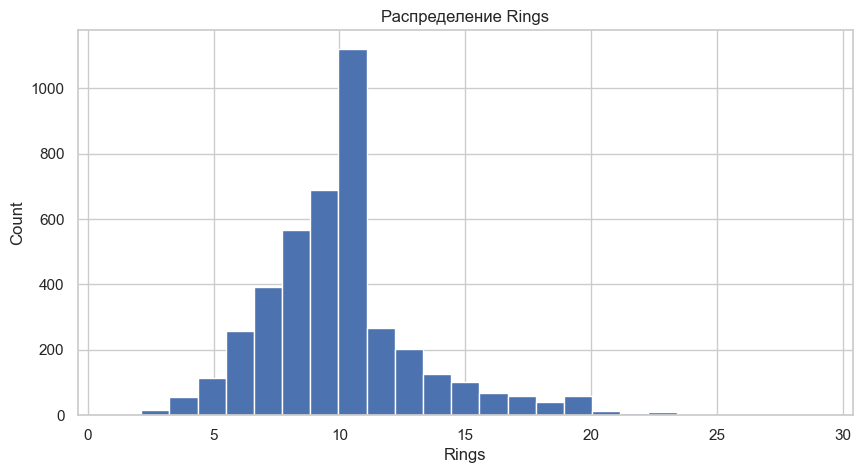

Сводка по таргету:
count    4176.000000
mean        9.934148
std         3.224416
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: Rings, dtype: float64


In [18]:
fig, ax = plt.subplots()
ax.hist(df["Rings"], bins=25)
ax.set_title("Распределение Rings")
ax.set_xlabel("Rings")
ax.set_ylabel("Count")
plt.show()

print("Сводка по таргету:")
print(df["Rings"].describe())

### Баланс категориального признака `Sex`

In [20]:
df["Sex"].value_counts(dropna=False).to_frame("count")

,count
Sex,
M,1528
I,1342
F,1306


### Распределения числовых признаков

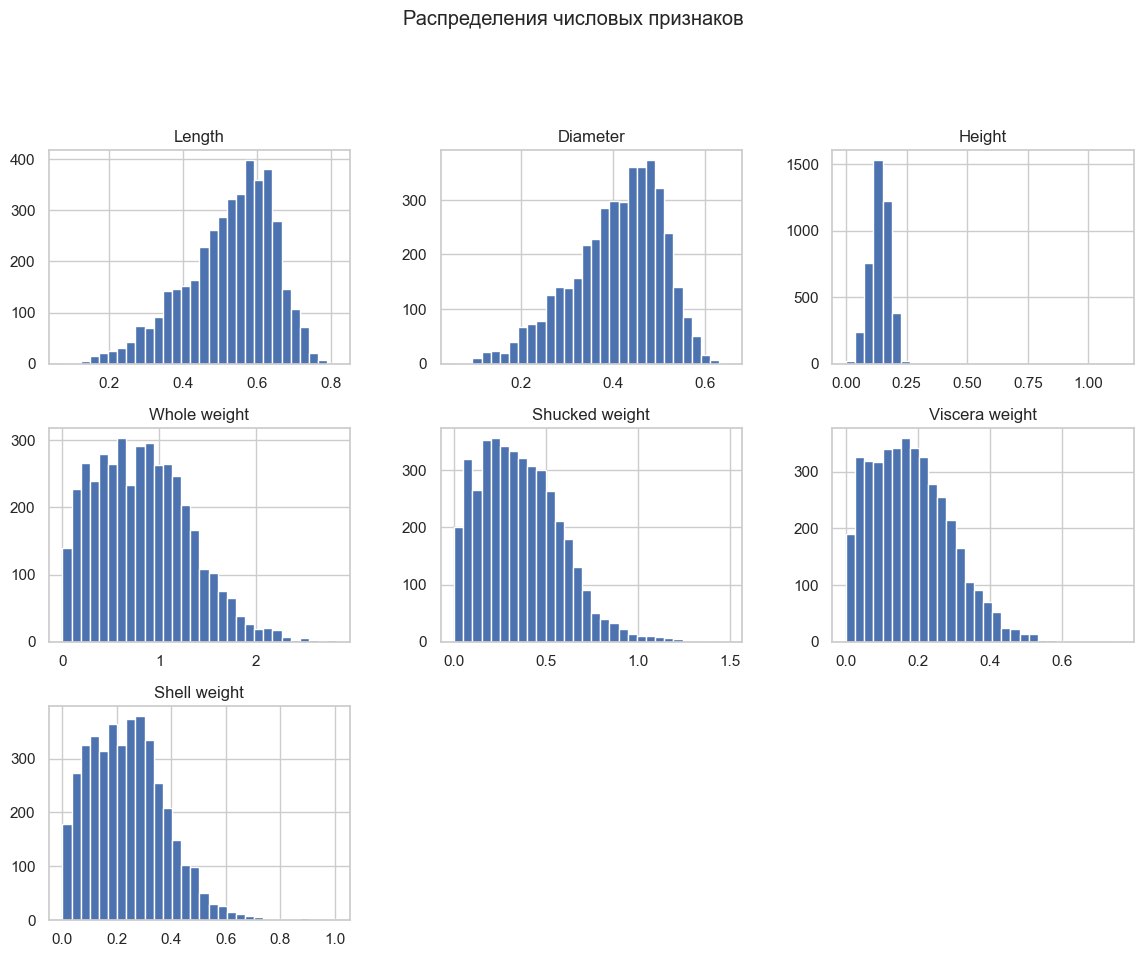

In [22]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("Rings")

df[num_cols].hist(bins=30, figsize=(14, 10))
plt.suptitle("Распределения числовых признаков", y=1.02)
plt.show()

### Выбросы (boxplot)

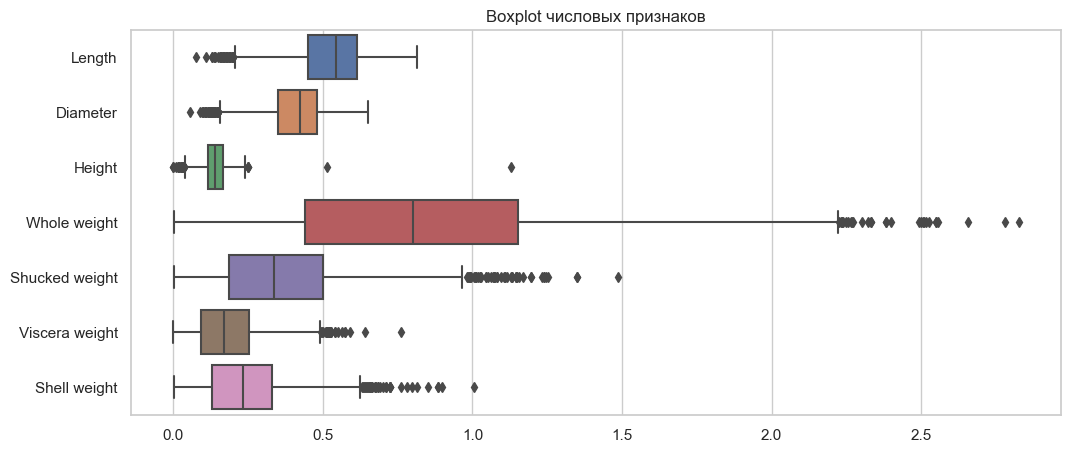

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=df[num_cols], orient="h", ax=ax)
ax.set_title("Boxplot числовых признаков")
plt.show()

## Взаимозависимость в данных

### 1. Корреляция: Pearson и Spearman

- **Pearson** показывает линейную связь.
- **Spearman** показывает монотонную связь (устойчивее к выбросам и нелинейностям).

Считаем обе корреляции на числовых признаках (и `Rings`) и сравниваем, что “сильнее всего связано” с таргетом.


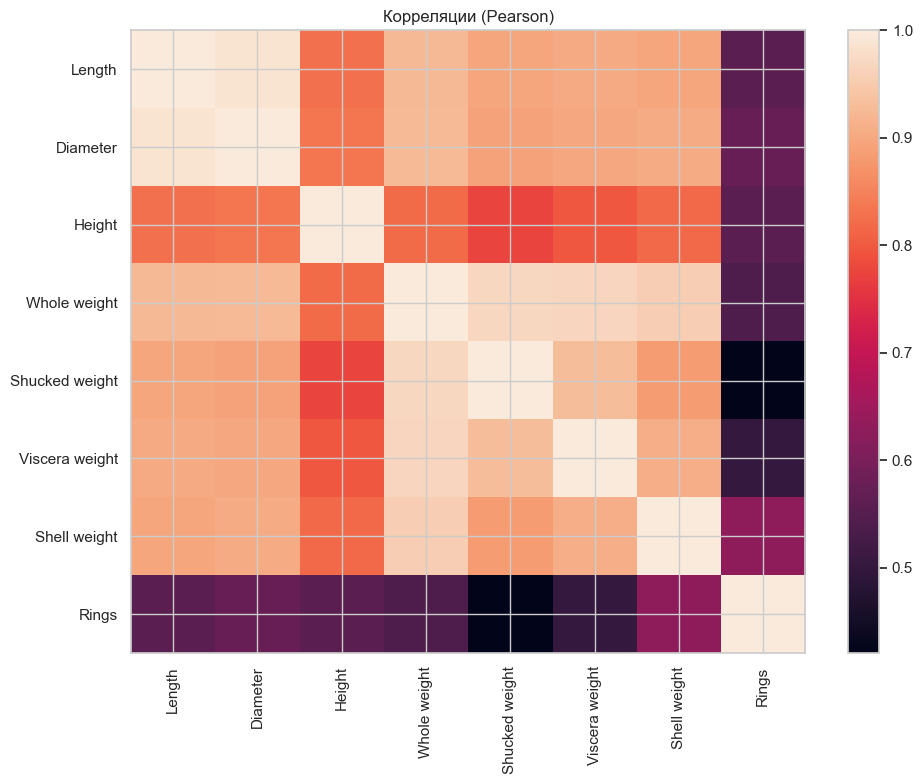

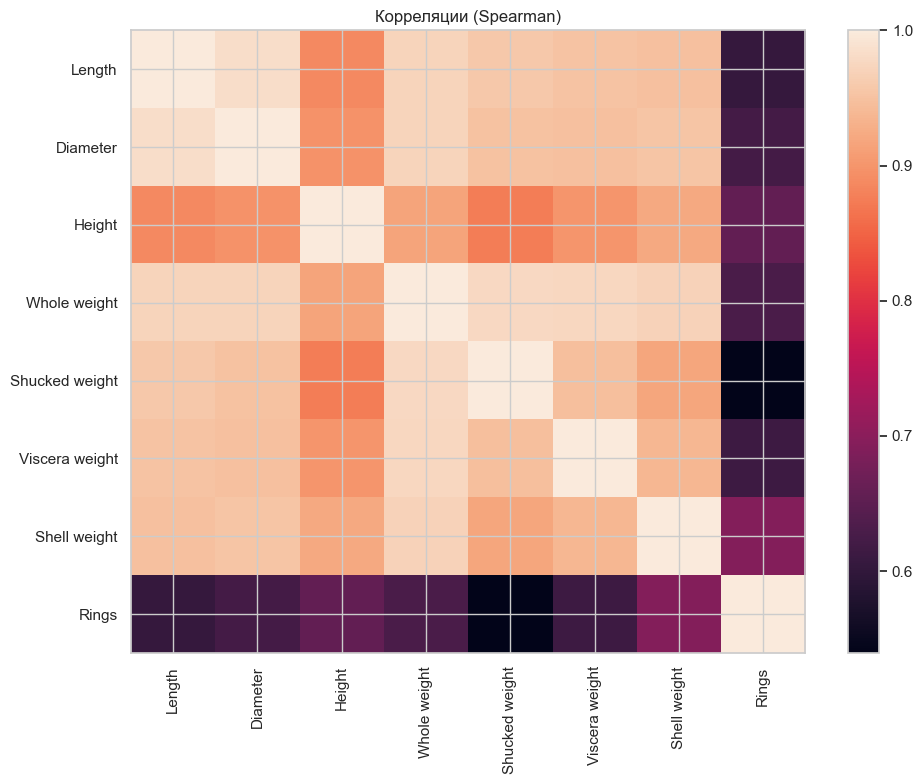

,Pearson_abs,Spearman_abs
Shell weight,0.627538,0.692373
Diameter,0.574628,0.622763
Height,0.557418,0.657584
Length,0.556680,0.604236
Whole weight,0.540348,0.630721
Viscera weight,0.503778,0.614227
Shucked weight,0.420838,0.539298


In [26]:
# Две корреляции: Pearson и Spearman (на числовых признаках)
cols_for_corr = num_cols + ["Rings"]

corr_pearson = df[cols_for_corr].corr(method="pearson", numeric_only=True)
corr_spearman = df[cols_for_corr].corr(method="spearman", numeric_only=True)

def plot_corr(corr, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_corr(corr_pearson, "Корреляции (Pearson)")
plot_corr(corr_spearman, "Корреляции (Spearman)")

# Топ связей с таргетом (по модулю)
corr_target_p = corr_pearson["Rings"].drop("Rings").abs().sort_values(ascending=False)
corr_target_s = corr_spearman["Rings"].drop("Rings").abs().sort_values(ascending=False)

top_corr = (
    pd.DataFrame({"Pearson_abs": corr_target_p, "Spearman_abs": corr_target_s})
      .sort_values("Pearson_abs", ascending=False)
)

display(top_corr.head(10))

# Чтобы последующие графики были воспроизводимы, выбираем Pearson как базовый вариант
corr_target = corr_target_p


### 2. Связь ключевых признаков с таргетом

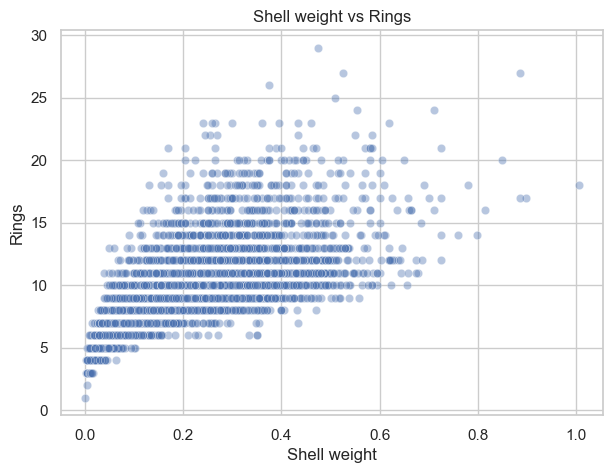

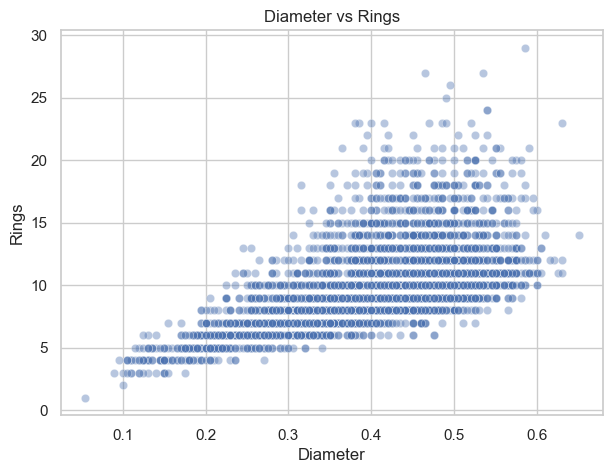

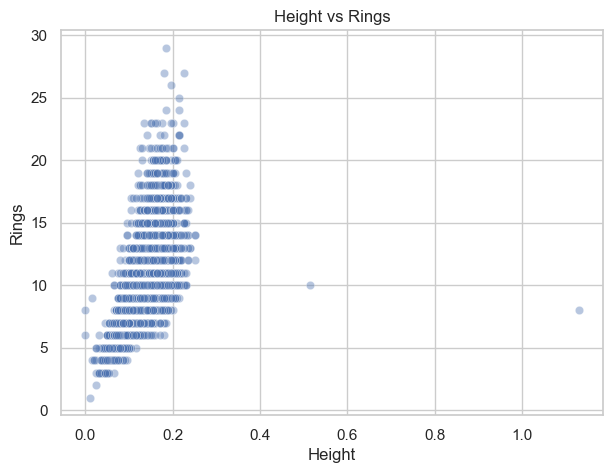

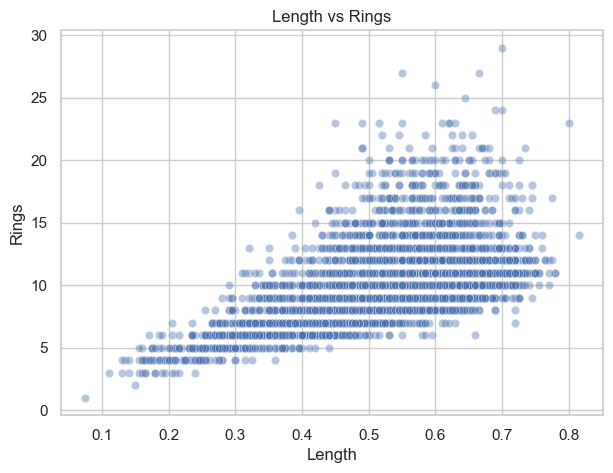

In [28]:
top_feats = corr_target.head(4).index.tolist()
for col in top_feats:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=df[col], y=df["Rings"], alpha=0.4)
    plt.title(f"{col} vs Rings")
    plt.show()

# Задача

**Целевая переменная:** `Rings` (количество «колец» — прокси возраста).  
Тип задачи — **регрессия**.

Что делаем:
- строим EDA (понимание распределений, выбросов, связей)
- готовим данные (в т.ч. **категориальные → числовые**)
- сравниваем **2 модели** по кросс‑валидации
- выбираем лучшую и проверяем качество на отложенной тестовой выборке
- оцениваем важность признаков (Permutation Importance)

Метрики качества:
- **RMSE** (чем меньше, тем лучше)
- **MAE** (чем меньше, тем лучше)
- **R²** (чем больше, тем лучше)


# Выбор моделей и оценка важности признаков

Здесь важны две идеи:

1. **Пайплайн (`Pipeline`)**  
   Все преобразования (OHE, масштабирование) и сама модель объединяются в единый объект.  
   Это защищает от утечки данных: трансформеры *обучаются только на train* при кросс‑валидации и на финальном фитте.

2. **Проверка важности признаков**  
   Мы используем несколько «слоёв» проверки:
   - в EDA смотрим корреляции/графики связи признаков с `Rings`
   - после обучения модели оцениваем **Permutation Importance** (перемешиваем один признак и смотрим, насколько падает качество)


### Подготовка данных и препроцессинг

Соберём единый `Pipeline`:
- `Sex` → One-Hot Encoding
- числовые признаки → стандартизация (`StandardScaler`)

In [32]:
# Разделяем признаки и целевую переменную
X = df.drop(columns=["Rings"])
y = df["Rings"].astype(int)

# Категориальные и числовые признаки выделяем явно (это полезно и для читаемости, и для контроля пайплайна)
cat_cols = ["Sex"]
num_cols = [c for c in X.columns if c not in cat_cols]

# ColumnTransformer позволяет применить разные преобразования к разным типам колонок:
# - к категориальным: OneHotEncoder (перевод категорий в набор 0/1 признаков)
# - к числовым: StandardScaler (стандартизация)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

# Сплитим данные до обучения трансформеров/моделей, чтобы не было data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((3340, 8), (836, 8))

#### Как выглядит матрица признаков после преобразований

Ниже — небольшой «снэпшот» первых строк после OHE + стандартизации.  
Это помогает проверить, что:
- категориальный `Sex` действительно развернулся в набор бинарных колонок
- числовые признаки стали сопоставимыми по масштабу (среднее ≈ 0, std ≈ 1)


In [34]:
# Покажем названия сгенерированных признаков и первые 5 строк после препроцессинга
preprocess.fit(X_train)

feature_names = preprocess.get_feature_names_out()
X_train_trans = preprocess.transform(X_train.iloc[:5])

pd.DataFrame(X_train_trans, columns=feature_names)


,cat__Sex_F,cat__Sex_I,cat__Sex_M,num__Length,num__Diameter,num__Height,num__Whole weight,num__Shucked weight,num__Viscera weight,num__Shell weight
0,0.0,1.0,0.0,0.212888,0.373225,-0.350225,-0.320545,-0.322787,-0.402547,-0.207643
1,0.0,1.0,0.0,-0.415134,-0.286015,-0.468144,-0.791700,-0.817340,-0.840296,-0.633669
2,1.0,0.0,0.0,-0.415134,-0.590279,-0.586062,-0.697877,-0.747334,-0.320469,-0.816252
3,1.0,0.0,0.0,-1.587444,-1.908758,-1.647329,-1.344441,-1.280277,-1.314524,-1.353260
4,1.0,0.0,0.0,0.589702,0.931043,0.946879,0.456555,0.365974,0.103601,1.081176


### Сравнение 2 моделей (кросс-валидация)

Сравниваем **ровно две** модели (как в задании):

1. **Ridge** — линейная модель с L2-регуляризацией  
   + интерпретируема (коэффициенты), хороша как «простая базовая линия»
2. **RandomForestRegressor** — ансамбль деревьев  
   + хорошо ловит нелинейности и взаимодействия признаков без ручного feature engineering

Оцениваем по 5-fold CV на train части. Используем метрики:
- RMSE (чем меньше, тем лучше)
- MAE (чем меньше, тем лучше)
- R² (чем больше, тем лучше)


In [36]:
# 2 модели по заданию
models = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# В sklearn метрики "loss" возвращаются со знаком минус (т.к. оптимизация направлена на максимум).
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

rows = []
for name, model in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])

    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )

    rows.append(
        {
            "model": name,
            "rmse_mean": -scores["test_rmse"].mean(),
            "rmse_std": scores["test_rmse"].std(),
            "mae_mean": -scores["test_mae"].mean(),
            "mae_std": scores["test_mae"].std(),
            "r2_mean": scores["test_r2"].mean(),
            "r2_std": scores["test_r2"].std(),
        }
    )

results = pd.DataFrame(rows).sort_values("rmse_mean").reset_index(drop=True)
results


,model,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
0,RandomForest,2.181145,0.078238,1.544383,0.029041,0.532643,0.036735
1,Ridge,2.231124,0.087882,1.588091,0.040254,0.511997,0.025121


### Обучение **обеих** моделей и проверка на тесте

В задании достаточно двух моделей — поэтому:

1) обучаем **Ridge** и **RandomForest** на train;  
2) считаем метрики на test;  
3) дальше анализируем важность признаков и “топ-k” **отдельно для каждой модели**.




In [38]:
from sklearn.metrics import mean_absolute_percentage_error
pipes = {}
test_scores = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    rmse = mean_squared_error(y_test, pred, squared=False)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred)

    pipes[name] = pipe
    test_scores.append({
        "model": name,
        "RMSE_test": rmse,
        "MAE_test": mae,
        "R2_test": r2,
        "MAPE_test": mape
    })

test_scores_df = (pd.DataFrame(test_scores)
                  .sort_values("RMSE_test")
                  .reset_index(drop=True))

display(test_scores_df)


,model,RMSE_test,MAE_test,R2_test,MAPE_test
0,Ridge,2.166051,1.566473,0.576331,0.157013
1,RandomForest,2.206612,1.551184,0.560315,0.153124


### Важность признаков (Permutation Importance) — **для каждой модели**

Permutation importance измеряет, насколько ухудшается качество модели, если **перемешать один признак**  
(оставив остальные как есть).


Ниже считаем permutation importance **для Ridge** и **для RandomForest** отдельно.


In [40]:
# Permutation importance по *преобразованным* признакам (после OHE и масштабирования)
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from scipy import sparse

def _to_dense(X):
    return X.toarray() if sparse.issparse(X) else X

def _clean_feature_names(names):
    # 'cat__Sex_F' -> 'Sex_F', 'num__Length' -> 'Length'
    out = []
    for n in names:
        out.append(n.split("__", 1)[1] if "__" in n else n)
    return out

imp_by_model = {}

for name, pipe in pipes.items():
    pre = pipe.named_steps["prep"]
    base_model = pipe.named_steps["model"]
    model = clone(base_model)

    # Применяем уже обученный на train препроцессор
    Xtr_train = pre.transform(X_train)
    Xtr_test  = pre.transform(X_test)

    # Делаем матрицу плотной (признаков мало, так проще и надежнее)
    Xtr_train_d = _to_dense(Xtr_train)
    Xtr_test_d  = _to_dense(Xtr_test)

    # Обучаем модель на преобразованных признаках
    model.fit(Xtr_train_d, y_train)

    perm = permutation_importance(
        model,
        Xtr_test_d,
        y_test,
        n_repeats=10,
        random_state=42,
        scoring="neg_root_mean_squared_error"
    )

    feature_names = _clean_feature_names(pre.get_feature_names_out())

    imp = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    }).sort_values("importance_mean", ascending=False)

    imp_by_model[name] = imp

# Печатаем top-8 + отдельно показываем 3 dummy-признака для Sex
for name, imp in imp_by_model.items():
    print(f"\nTop-8 признаков по permutation importance для: {name}")
    display(imp.head(8))

    print("Важность категорий Sex (3 one-hot признака):")
    display(imp[imp["feature"].str.startswith("Sex_")].sort_values("feature"))



Top-8 признаков по permutation importance для: Ridge


,feature,importance_mean,importance_std
6,Whole weight,4.236508,0.096869
7,Shucked weight,4.176329,0.131218
4,Diameter,0.704193,0.026561
9,Shell weight,0.648792,0.027756
8,Viscera weight,0.438082,0.032996
5,Height,0.104593,0.010315
1,Sex_I,0.045884,0.007909
0,Sex_F,0.011902,0.004476


Важность категорий Sex (3 one-hot признака):


,feature,importance_mean,importance_std
0,Sex_F,0.011902,0.004476
1,Sex_I,0.045884,0.007909
2,Sex_M,0.011164,0.005765



Top-8 признаков по permutation importance для: RandomForest


,feature,importance_mean,importance_std
9,Shell weight,2.283786,0.045001
7,Shucked weight,1.299074,0.051752
6,Whole weight,0.202261,0.028450
5,Height,0.110759,0.017157
8,Viscera weight,0.080606,0.012440
1,Sex_I,0.059103,0.013073
4,Diameter,0.054362,0.014182
3,Length,0.030598,0.011431


Важность категорий Sex (3 one-hot признака):


,feature,importance_mean,importance_std
0,Sex_F,-0.002058,0.001620
1,Sex_I,0.059103,0.013073
2,Sex_M,0.002572,0.002584


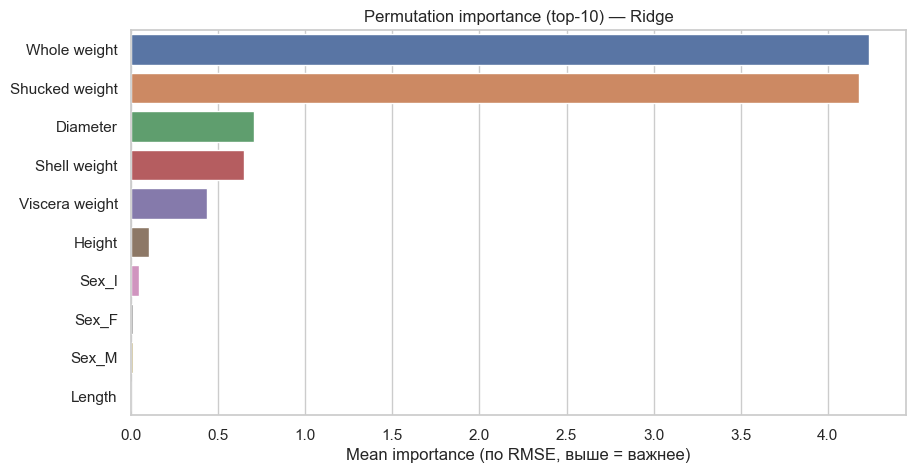

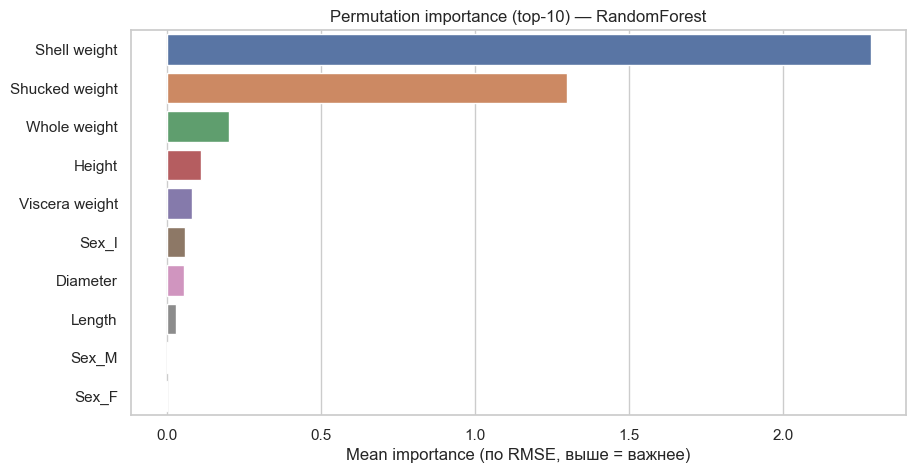

In [41]:
# Визуализация top-10 важностей для каждой модели
for name, imp in imp_by_model.items():
    plt.figure(figsize=(10, 5))
    sns.barplot(data=imp.head(10), x="importance_mean", y="feature")
    plt.title(f"Permutation importance (top-10) — {name}")
    plt.xlabel("Mean importance (по RMSE, выше = важнее)")
    plt.ylabel("")
    plt.show()


# Обучение на топ-k признаках (отдельно для каждой модели)

Сравним качество:

- **на всех признаках** (это уже посчитано выше на `test`)  
- **на топ-4 признаках** по permutation importance (для каждой модели свой top-4)




## На всех данных (test)

Метрики на всех признаках — это таблица `test_scores_df` выше (после обучения двух моделей).


In [44]:
display(test_scores_df)

,model,RMSE_test,MAE_test,R2_test,MAPE_test
0,Ridge,2.166051,1.566473,0.576331,0.157013
1,RandomForest,2.206612,1.551184,0.560315,0.153124


## На топ-4 признаках по permutation importance (отдельно для каждой модели)

In [46]:
top_k = 4
top_features_by_model = {name: imp["feature"].head(top_k).tolist()
                         for name, imp in imp_by_model.items()}

top_features_by_model


{'Ridge': ['Whole weight', 'Shucked weight', 'Diameter', 'Shell weight'],
 'RandomForest': ['Shell weight', 'Shucked weight', 'Whole weight', 'Height']}

In [47]:
# Обучаем каждую модель только на её top-4 *преобразованных* признаках и сравниваем метрики
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import sparse
from sklearn.metrics import mean_absolute_percentage_error
def _clean_feature_names(names):
    return [n.split("__", 1)[1] if "__" in n else n for n in names]

def _subset_transformed(pre, X, feature_names_clean, top_features):
    idx = [feature_names_clean.index(f) for f in top_features]
    Xt = pre.transform(X)
    if sparse.issparse(Xt):
        Xt = Xt[:, idx].toarray()
    else:
        Xt = Xt[:, idx]
    return Xt

top_k = 4
topk_scores = []

for name, pipe in pipes.items():
    pre = pipe.named_steps["prep"]
    base_model = pipe.named_steps["model"]
    model = clone(base_model)

    feature_names_clean = _clean_feature_names(pre.get_feature_names_out())
    top_features = imp_by_model[name]["feature"].head(top_k).tolist()

    X_train_top = _subset_transformed(pre, X_train, feature_names_clean, top_features)
    X_test_top  = _subset_transformed(pre, X_test,  feature_names_clean, top_features)

    model.fit(X_train_top, y_train)
    pred = model.predict(X_test_top)

    rmse = mean_squared_error(y_test, pred, squared=False)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred)

    topk_scores.append({
        "model": name,
        "features_used": top_k,
        "top_features": ", ".join(top_features),
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "MAPE": mape
    })

topk_scores_df = pd.DataFrame(topk_scores).sort_values("RMSE")
display(topk_scores_df)


,model,features_used,top_features,RMSE,MAE,R2,MAPE
0,Ridge,4,"Whole weight, Shucked weight, Diameter, Shell ...",2.229046,1.623930,0.551330,0.164658
1,RandomForest,4,"Shell weight, Shucked weight, Whole weight, He...",2.289978,1.606065,0.526465,0.159737


## Выводы

В итоге, что при обучении по всем признакам, что только по важнейшим 4м, модели показывают примерно одинаковые результаты. При этом результаты метрик моделей, обученных на всём множестве, не сильно превосходят результаты полученные при обучении только на 4х самых важных. 
